<a href="https://colab.research.google.com/github/YugantGotmare/Diabetic_Retinopathy/blob/main/Diabetic_Retinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

100% 425M/427M [00:22<00:00, 22.8MB/s]
100% 427M/427M [00:22<00:00, 20.2MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/diabetic-retinopathy-224x224-gaussian-filtered.zip')
zip_ref.extractall('/content/Data')
zip_ref.close()

In [7]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Dense,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [11]:
path = '/content/Data/gaussian_filtered_images/gaussian_filtered_images'

In [12]:

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    # shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

test_data= tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 3662 files belonging to 5 classes.
Using 2930 files for training.
Found 3662 files belonging to 5 classes.
Using 732 files for validation.


In [13]:
class_names = train_data.class_names
class_names

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

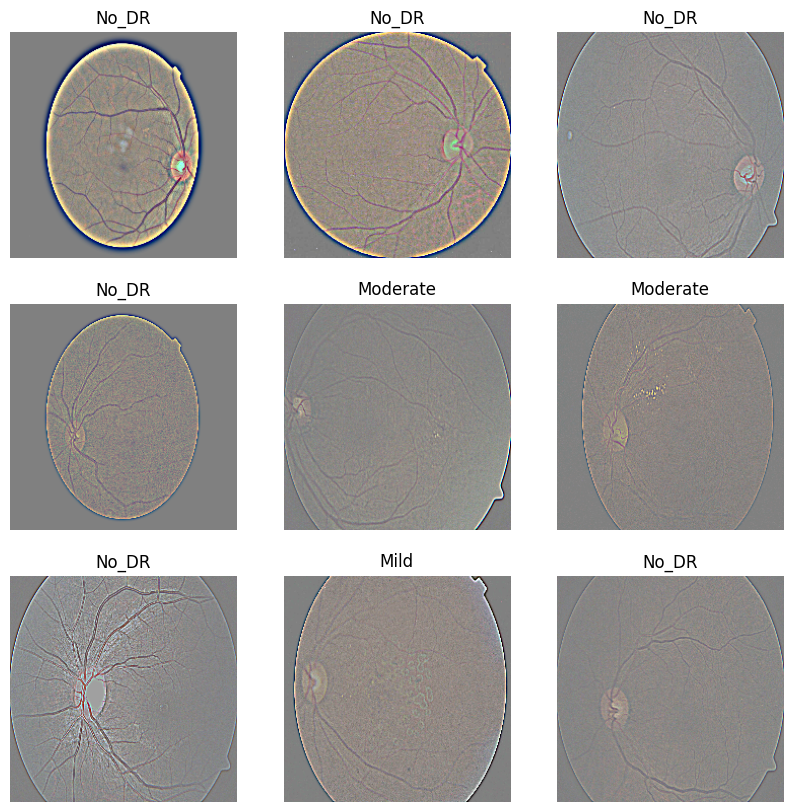

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i+1)
      plt.imshow(images[i].numpy().astype('uint8'))
      plt.title(class_names[labels[i]])
      plt.axis('off')

In [27]:
base_model = keras.applications.MobileNetV3Small(input_shape=(224, 224, 3),
                                                classes=400,
                                                include_top=False,
                                                weights='imagenet')

In [76]:
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

In [77]:
data_augmentation = keras.models.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.2)
])

In [78]:
num_classes = len(class_names)

inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = keras.applications.mobilenet_v3.preprocess_input(x)
x = base_model(x, training=True)  # Set training to True for fine-tuning
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)  # Increase dropout rate for regularization
x = keras.layers.Dense(256, activation='relu')(x)  # Additional dense layer
x = keras.layers.Dropout(0.3)(x)  # Additional dropout layer
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [79]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)  # Experiment with different optimizers
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_7   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_17 (Dropout)        (None, 576)               0         
                                                                 
 dense_17 (Dense)            (None, 256)               1477

In [80]:
initial_epochs = 10

early = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=1, verbose=1, mode='auto')

check = ModelCheckpoint(monitor='val_accuracy',filepath="./Retino_bestmodel.h5", save_best_only=True, verbose=1, mode='auto')

call = [early,check]

In [86]:
history = model.fit(train_data,
validation_data=test_data,
epochs=initial_epochs,
callbacks=call)

Epoch 1/10
91/92 [============================>.] - ETA: 0s - loss: 0.5370 - accuracy: 0.7984
Epoch 1: val_accuracy did not improve from 0.79372
92/92 [==============================] - 11s 108ms/step - loss: 0.5360 - accuracy: 0.7986 - val_loss: 0.6274 - val_accuracy: 0.7828
Epoch 2/10
92/92 [==============================] - ETA: 0s - loss: 0.5347 - accuracy: 0.7980
Epoch 2: val_accuracy improved from 0.79372 to 0.80874, saving model to ./Retino_bestmodel.h5
92/92 [==============================] - 9s 92ms/step - loss: 0.5347 - accuracy: 0.7980 - val_loss: 0.5571 - val_accuracy: 0.8087
Epoch 3/10
92/92 [==============================] - ETA: 0s - loss: 0.5195 - accuracy: 0.8020
Epoch 3: val_accuracy improved from 0.80874 to 0.81694, saving model to ./Retino_bestmodel.h5
92/92 [==============================] - 10s 107ms/step - loss: 0.5195 - accuracy: 0.8020 - val_loss: 0.5741 - val_accuracy: 0.8169
Epoch 3: early stopping


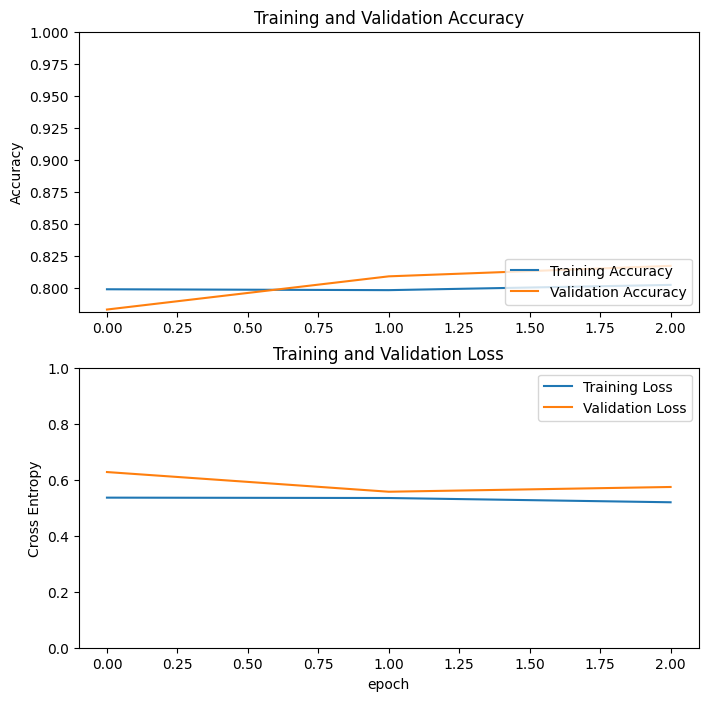

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [88]:
test_loss, test_acc = model.evaluate(test_data)
print('test accuracy : ', test_acc)

23/23 [==============================] - 2s 54ms/step - loss: 0.5806 - accuracy: 0.8169
test accuracy :  0.8169398903846741


In [89]:
results = model.evaluate(test_data, verbose=0)

In [90]:
print("Test Loss: {:.5f}".format(results[0]))
print("Accuracy on the test set: {:.2f}%".format(results[1] * 100))

Test Loss: 0.61549
Accuracy on the test set: 81.15%


1/1 [==============================] - 1s 1s/step


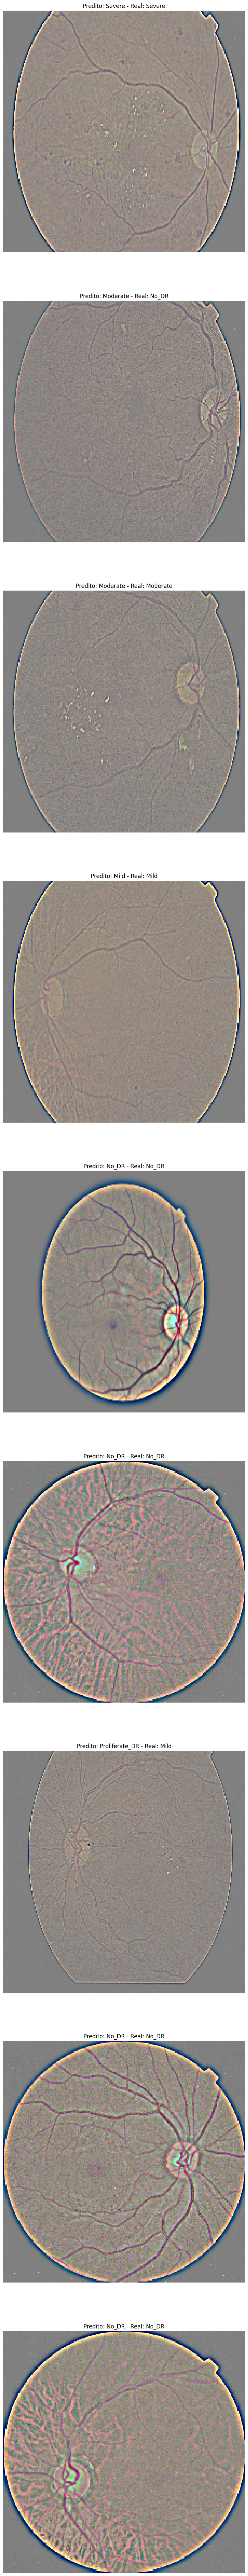

In [91]:
plt.figure(figsize=(10, 100))
for images, labels in test_data.take(1):
  prediction = model.predict(images,batch_size=32)
  for i in range(9):
    ax = plt.subplot(9, 1, i+1)
    pred = np.argmax(prediction[i])
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(f'Predito: {class_names[pred]} - Real: {class_names[labels[i].numpy()]}')
    plt.axis('off')
#Visualize